In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tnrange, tqdm_notebook
import gc
import operator

In [2]:
sns.set_context('talk')

In [3]:
pd.set_option('display.max_columns', 500)

In [4]:
import warnings
warnings.filterwarnings('ignore', message='Changing the shape of non-C contiguous array')

# Read the data

In [5]:
dfXtrain = pd.read_csv('preprocessed_csv/train_4.csv', index_col='id', sep=';')
dfXtest = pd.read_csv('preprocessed_csv/test_4.csv', index_col='id', sep=';')
dfYtrain = pd.read_csv('preprocessed_csv/y_train_4.csv', header=None, names=['ID', 'COTIS'], sep=';')

In [6]:
dfYtrain = dfYtrain.set_index('ID')

# Preprocessing

Вынесем var14, department и subreg.

In [7]:
dropped_col_names = ['department', 'subreg', 'ext_dep'] 

def drop_cols(df):
    return df.drop(dropped_col_names, axis=1), df[dropped_col_names]

In [8]:
train, dropped_train = drop_cols(dfXtrain)
test, dropped_test = drop_cols(dfXtest)

Добавим инфу о величине города из subreg'a

In [9]:
def add_big_city_cols(df, dropped_df):
    df['big'] = np.where(dropped_df['subreg'] % 100 == 0, 1, 0)
    df['average'] = np.where(dropped_df['subreg'] % 10 == 0, 1, 0)
    df['average'] = df['average'] - df['big']
    df['small'] = 1 - df['big'] - df['average']
    return df

In [10]:
train = add_big_city_cols(train, dropped_train)
test = add_big_city_cols(test, dropped_test)

Декодируем оставшиеся категориальные признаки

In [11]:
categorical = list(train.select_dtypes(exclude=[np.number]).columns)
categorical

['marque', 'energie_veh', 'profession', 'var6', 'var8', 'var14']

In [12]:
list(test.select_dtypes(exclude=[np.number]).columns)

['marque', 'energie_veh', 'profession', 'var6', 'var8', 'var14']

In [13]:
for col in categorical:
    print(col, train[col].nunique(), test[col].nunique())

marque 154 73
energie_veh 5 5
profession 17 17
var6 5 5
var8 23 19
var14 8 1


energie_veh и var6 с помощью get_dummies

In [14]:
train.energie_veh.unique()

array(['gpl', 'hybride essence', 'electricite', 'gazole', 'essence', nan], dtype=object)

In [15]:
test.energie_veh.unique()

array(['essence', 'gazole', 'gpl', 'hybride essence', nan, 'electricite'], dtype=object)

In [16]:
small_cat = ['energie_veh', 'var6']

In [17]:
train = pd.get_dummies(train, columns=small_cat)
test = pd.get_dummies(test, columns=small_cat)

Теперь посмотрим на остальные

In [18]:
len(set(train.profession.values) - set(test.profession.values))

0

In [19]:
len(set(train.var8.values) - set(test.var8.values))

4

In [20]:
len(set(test.var8.values) - set(train.var8.values))

0

In [21]:
len(set(train.marque.values) - set(test.marque.values))

83

In [22]:
len(set(test.marque.values) - set(train.marque.values))

2

In [23]:
set(test.marque.values) - set(train.marque.values)

{'GEELY', 'SOVAM'}

In [24]:
test[test.marque == 'GEELY']

,marque,puis_fiscale,anc_veh,kmage_annuel,crm,profession,var1,var2,var3,var4,var5,var7,var8,var9,var10,var11,var13,var14,var15,var16,var17,var18,var19,var20,var21,var22,age,big,average,small,energie_veh_electricite,energie_veh_essence,energie_veh_gazole,energie_veh_gpl,energie_veh_hybride essence,var6_A,var6_B,var6_C,var6_D,var6_N
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
305916,GEELY,5,0,7421,50,technicien,6.0,3,272,0,1,1.0,M1,94,150,0,4,N,2,4.0,1,20,0,1,1,4,25.0,0,0,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [25]:
test[test.marque == 'SOVAM']

,marque,puis_fiscale,anc_veh,kmage_annuel,crm,profession,var1,var2,var3,var4,var5,var7,var8,var9,var10,var11,var13,var14,var15,var16,var17,var18,var19,var20,var21,var22,age,big,average,small,energie_veh_electricite,energie_veh_essence,energie_veh_gazole,energie_veh_gpl,energie_veh_hybride essence,var6_A,var6_B,var6_C,var6_D,var6_N
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
318867,SOVAM,9,19,17000,50,"agent, employe",28.0,5,372,7,1,20.0,K2,0,0,19,5,N,3,1.0,1,19,0,0,1,0,47.0,0,0,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


profession и var8 тоже в dummy

In [26]:
middle_cat = ['profession', 'var8', 'marque', 'var14']

In [27]:
bigX = pd.concat([train, test])

In [28]:
bigX.shape

(330000, 40)

In [29]:
bigX = pd.get_dummies(bigX, columns=middle_cat)

In [30]:
bigX.shape

(330000, 240)

In [31]:
bigX.fillna(-9999, inplace=True)

Расположим столбцы в нужном порядке, добавим константный столбец

In [32]:
bigX.crm /= 100

In [33]:
first_col_list = ['crm', 'puis_fiscale']
col_list = first_col_list + sorted(list(set(bigX.columns) - set(first_col_list)))

In [34]:
bigX = bigX[col_list]

In [35]:
y_train = np.array(dfYtrain)
train = bigX.loc[train.index]
x_train = np.array(train)
test = bigX.loc[test.index]
x_test = np.array(test)

In [36]:
x_train.shape

(300000, 240)

In [37]:
x_test.shape

(30000, 240)

# Save routines

In [38]:
dfYtest = pd.DataFrame({'ID': dfXtest.index, 'COTIS': np.zeros(test.shape[0])})
dfYtest = dfYtest[['ID', 'COTIS']]
dfYtest.head()

,ID,COTIS
0,300001,0.0
1,300002,0.0
2,300003,0.0
3,300004,0.0
4,300005,0.0


In [39]:
def save_to_file(y, file_name):
    dfYtest['COTIS'] = y
    dfYtest.to_csv('results/{}'.format(file_name), index=False, sep=';')

In [40]:
model_name = 'ldtr'
dfYtest_stacking = pd.DataFrame({'ID': dfXtrain.index, model_name: np.zeros(train.shape[0])})
dfYtest_stacking = dfYtest_stacking[['ID', model_name]]
dfYtest_stacking.head()

,ID,ldtr
0,1,0.0
1,2,0.0
2,3,0.0
3,4,0.0
4,5,0.0


In [41]:
def save_to_file_stacking(y, file_name):
    dfYtest_stacking[model_name] = y
    dfYtest_stacking.to_csv('stacking/{}'.format(file_name), index=False, sep=';')

# Train model

In [42]:
def plot_quality(grid_searcher, param_name):
    means = []
    stds = []
    for elem in grid_searcher.grid_scores_:
        means.append(np.mean(elem.cv_validation_scores))
        stds.append(np.sqrt(np.var(elem.cv_validation_scores)))
    means = np.array(means)
    stds = np.array(stds)
    
    params = grid_searcher.param_grid
    
    plt.figure(figsize=(10, 6))
    plt.plot(params[param_name], means)
    plt.fill_between(params[param_name], \
                 means + stds, means - stds, alpha = 0.3, facecolor='blue')
    plt.xlabel(param_name)
    plt.ylabel('MAPE')

In [43]:
def mape(y_true, y_pred): 
    return -np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [44]:
def mape_scorer(est, X, y):
    gc.collect()
    return mape(y, est.predict(X))

In [397]:
class MyGS():
    class Element():
        def __init__(self):
            self.cv_validation_scores = []
        
        
        def add(self, score):
            self.cv_validation_scores.append(score)
    
    
    def __init__(self, param_grid, name, n_folds):
        self.param_grid = {name: param_grid}
        self.grid_scores_ = [MyGS.Element() for item in param_grid]
        self.est = None
        
    
    def add(self, score, param_num):
        self.grid_scores_[param_num].add(score)
        

In [46]:
validation_index = (dropped_train.ext_dep == 10) | (dropped_train.ext_dep > 900)
train_index = ~validation_index

In [47]:
subtrain, validation = train[train_index], train[validation_index]
x_subtrain = np.array(subtrain)
x_validation = np.array(validation)

ysubtrain, yvalidation = dfYtrain[train_index], dfYtrain[validation_index]
y_subtrain = np.array(ysubtrain).flatten()
y_validation = np.array(yvalidation).flatten()

In [48]:
validation.shape

(33155, 240)

In [49]:
from sklearn.tree import LinearDecisionTreeRegressor as LDTR

In [50]:
from sklearn.tree import DecisionTreeRegressor

In [51]:
from sklearn.ensemble import ExtraTreesRegressor

In [52]:
%%time
est = ExtraTreesRegressor(n_estimators=10, max_features=None, 
                          max_depth=None, n_jobs=-1, random_state=42).fit(
    X=x_subtrain, y=np.log(y_subtrain), sample_weight=None)

CPU times: user 2min 48s, sys: 312 ms, total: 2min 48s
Wall time: 49.5 s


In [53]:
y_pred = est.predict(x_validation)
mape(y_validation, np.exp(y_pred))

-10.500153732173761

In [54]:
gc.collect()

28

In [55]:
sample_weight_subtrain = np.power(y_subtrain, -1)

In [56]:
%%time
est = DecisionTreeRegressor(max_features=None, 
                          max_depth=None, random_state=42).fit(
    X=x_subtrain, y=np.log(y_subtrain), sample_weight=sample_weight_subtrain)

CPU times: user 25.1 s, sys: 88 ms, total: 25.2 s
Wall time: 25.2 s


In [57]:
y_pred = est.predict(x_validation)
mape(y_validation, np.exp(y_pred))

-14.093038650542422

In [58]:
gc.collect()

9

In [59]:
sample_weight_subtrain = np.power(y_subtrain, -1)

In [66]:
%%time
est = LDTR(max_features=None, max_depth=15, random_state=42,
           n_coefficients=2, n_first_dropped=2, const_term=True, min_samples_leaf=40).fit(
    X=x_subtrain, y=y_subtrain, sample_weight=sample_weight_subtrain)

CPU times: user 15.5 s, sys: 48 ms, total: 15.6 s
Wall time: 15.6 s


In [67]:
y_pred = est.predict(x_validation)
mape(y_validation, y_pred)

-9.9656456942651594

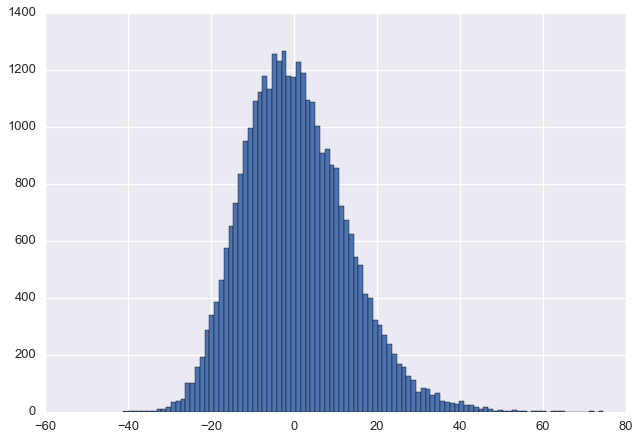

In [68]:
plt.hist(100 * (y_pred - y_validation) / y_validation , bins=100)
plt.show()

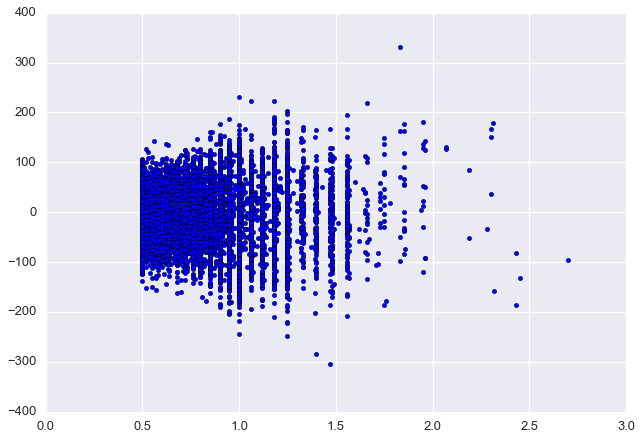

In [69]:
plt.scatter(x_validation[:, 0], y_pred - y_validation)
#plt.scatter(x_validation[:, 0], y_validation, color='g')
plt.show()

In [70]:
%%time
est = LDTR(max_features=None, max_depth=15, random_state=42,
           n_coefficients=2, n_first_dropped=2, const_term=True, min_samples_leaf=40).fit(
    X=x_subtrain, y=y_subtrain, sample_weight=sample_weight_subtrain)

CPU times: user 15.6 s, sys: 20 ms, total: 15.6 s
Wall time: 15.6 s


In [71]:
y_pred = est.predict(x_validation)
mape(y_validation, y_pred)

-9.9656456942651594

In [72]:
sample_weight_subtrain = np.power(y_subtrain, -1)

In [73]:
from sklearn.ensemble import BaggingRegressor

In [74]:
gc.collect()

21694

In [75]:
ldtr = LDTR(max_features=None, max_depth=None,
           n_coefficients=2, n_first_dropped=2, const_term=True, min_samples_leaf=20)

In [76]:
%%time
est = BaggingRegressor(base_estimator=ldtr, n_estimators=50, max_samples=1.0,
                       n_jobs=-1, random_state=42).fit(
            X=x_subtrain, y=y_subtrain, sample_weight=sample_weight_subtrain)

CPU times: user 4.34 s, sys: 852 ms, total: 5.19 s
Wall time: 5min 19s


In [77]:
y_pred = est.predict(x_validation)
mape(y_validation, y_pred)

-9.37854439817154

50 деревьев достаточно

In [196]:
%%time
est = BaggingRegressor(base_estimator=ldtr, n_estimators=200, max_samples=1.0,
                       n_jobs=-1, random_state=42).fit(
            X=x_subtrain, y=y_subtrain, sample_weight=sample_weight_subtrain)

CPU times: user 5.99 s, sys: 1.97 s, total: 7.96 s
Wall time: 22min 14s


In [199]:
y_pred = est.predict(x_subtrain)
mape(y_subtrain, y_pred)

-7.8671523175074798

In [204]:
y_pred = est.predict(x_validation)
mape(y_validation, y_pred)

-9.351312980568748

Конец закешированного

In [78]:
scores = []
coeffs = np.array(np.arange(0.9, 1.1, 0.01))
for coeff in coeffs:
    scores.append(mape(y_validation, coeff * y_pred))

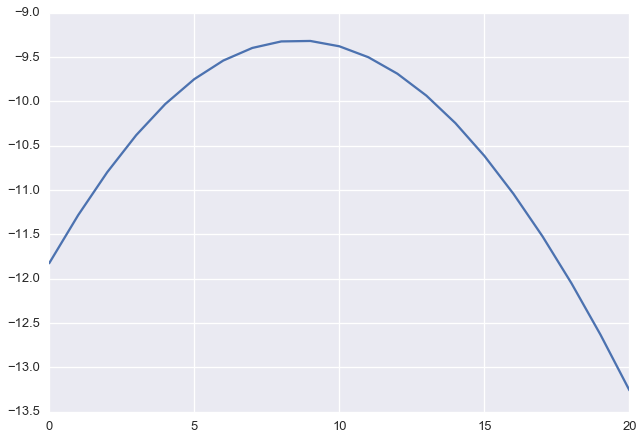

In [79]:
plt.plot(scores)

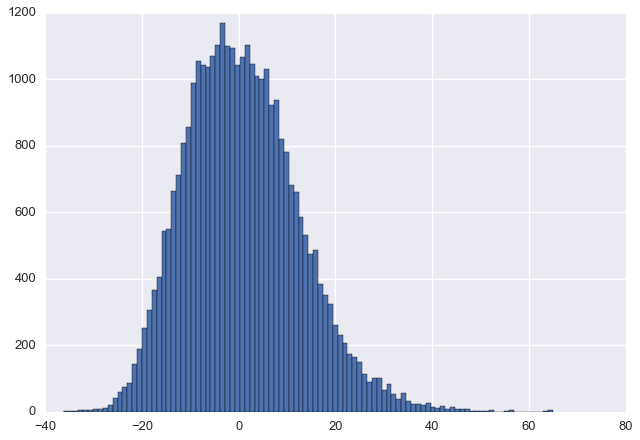

In [80]:
plt.hist(100 * (y_pred - y_validation) / y_validation , bins=100)
plt.show()

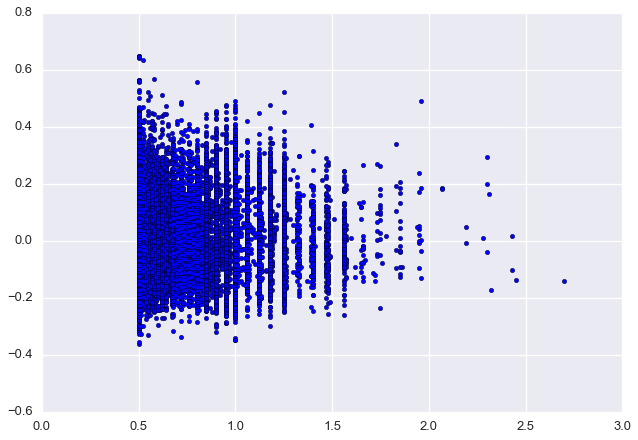

In [82]:
plt.scatter(x_validation[:, 0], (y_pred - y_validation) / y_validation)
#plt.scatter(x_validation[:, 0], y_validation, color='g')
plt.show()

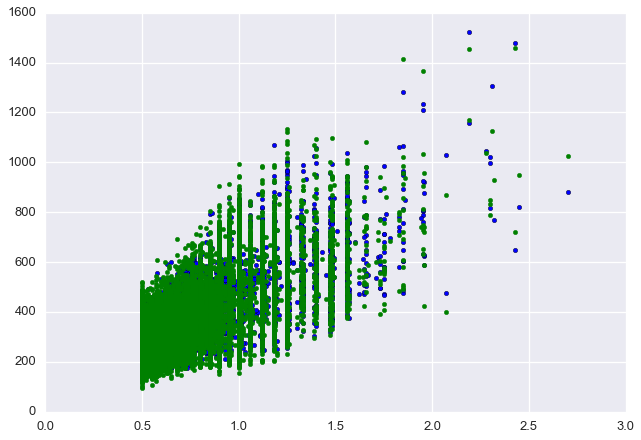

In [83]:
plt.scatter(x_validation[:, 0], y_pred)
plt.scatter(x_validation[:, 0], y_validation, color='g')
plt.show()

In [217]:
y_train.min()

94.780000000000001

In [297]:
intercept = 50

In [298]:
%%time
est = LDTR(max_features=None, max_depth=25, random_state=42,
           n_coefficients=1, n_first_dropped=1, const_term=False, min_samples_leaf=50).fit(
    X=x_subtrain, y=y_subtrain - intercept, sample_weight=sample_weight_subtrain)

CPU times: user 14 s, sys: 48 ms, total: 14 s
Wall time: 14 s


In [299]:
y_pred = est.predict(x_validation) + intercept
mape(y_validation, y_pred)

-9.7496225563659582

In [271]:
y_pred = est.predict(x_validation) + intercept
mape(y_validation, y_pred)

-9.7496225563659582

In [281]:
coeffs_pred = est.predict_mean_and_coefficients(x_subtrain[:, 1:])

In [282]:
coeffs_pred.mean(axis=0)

array([  9.98273658e+06,   3.92031663e+02,   9.61953262e-01])

In [283]:
coeffs_pred.std(axis=0)

array([  6.17564282e+06,   1.05533632e+02,   3.96712877e+00])

In [284]:
coeffs_pred.min(axis=0)

array([  1.61505639e+05,   1.51761361e+02,  -1.54052004e+01])

In [276]:
y_pred = est.predict(x_subtrain) + intercept
mape(y_subtrain, y_pred)

-9.4802300247441789

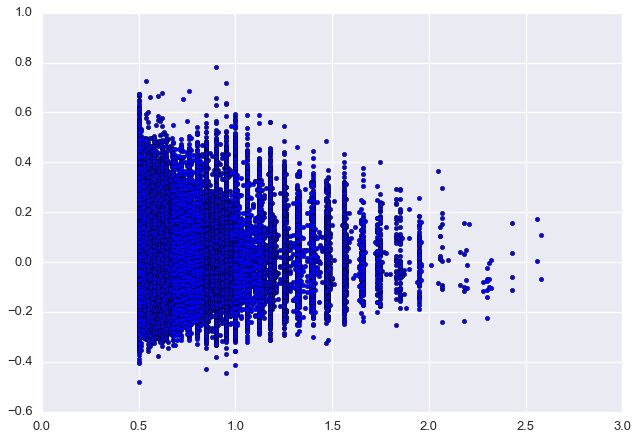

In [277]:
plt.scatter(x_subtrain[:, 0], (y_pred - y_subtrain) / y_subtrain)
#plt.scatter(x_validation[:, 0], y_validation, color='g')
plt.show()

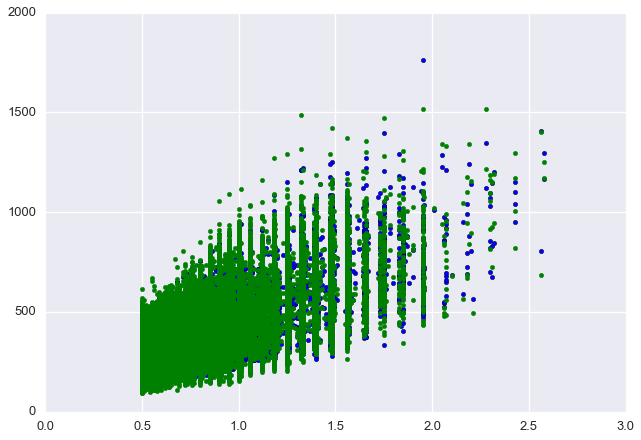

In [278]:
plt.scatter(x_subtrain[:, 0], y_pred)
plt.scatter(x_subtrain[:, 0], y_subtrain, color='g')
plt.show()

In [332]:
sample_weight_subtrain = np.power(np.log((y_subtrain - intercept)/x_subtrain[:, 0]), -1)

In [342]:
%%time
est = ExtraTreesRegressor(n_estimators=10, max_features=None, 
                          max_depth=None, n_jobs=-1, random_state=42).fit(
    X=x_subtrain, y=np.log((y_subtrain - intercept)/x_subtrain[:, 0]), sample_weight=sample_weight_subtrain)

CPU times: user 2min 56s, sys: 480 ms, total: 2min 56s
Wall time: 51.8 s


In [344]:
y_pred = np.exp(est.predict(x_validation)) * x_validation[:, 0] + intercept
mape(y_validation, y_pred)

-9.826014111519294

In [307]:
y_pred = np.exp(est.predict(x_validation)) * x_validation[:, 0] + intercept
mape(y_validation, y_pred)

-9.8526466197898426

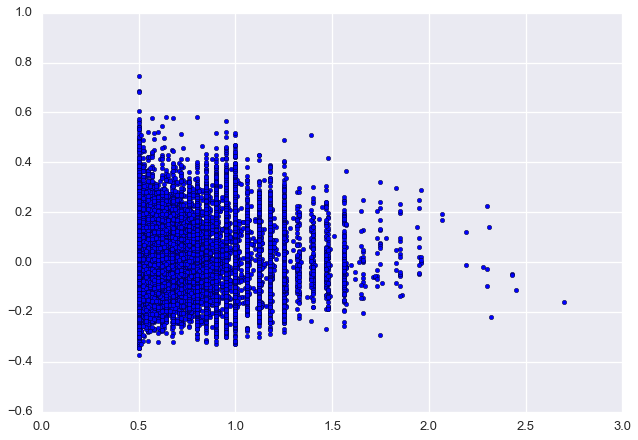

In [345]:
plt.scatter(x_validation[:, 0], (y_pred - y_validation) / y_validation)
#plt.scatter(x_validation[:, 0], y_validation, color='g')
plt.show()

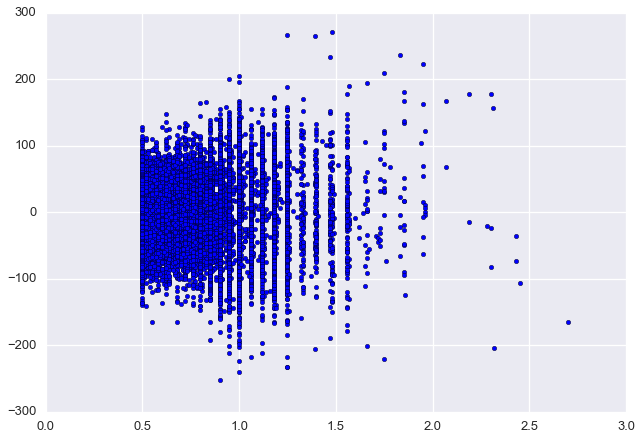

In [346]:
plt.scatter(x_validation[:, 0], (y_pred - y_validation))
#plt.scatter(x_validation[:, 0], y_validation, color='g')
plt.show()

In [347]:
gc.collect()

8411

In [348]:
import xgboost as xgb

/home/alexey/.environments/ml/lib/python3.4/site-packages/sklearn/cross_validation.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [444]:
def grid_search(x_train, y_train, x_validation, y_validation, scorer, weights):
    param =   {'base_score':0.5, 'colsample_bylevel':1, 'colsample_bytree':1, 'gamma':0,
               'eta':0.15, 'max_delta_step':0, 'max_depth':15,
               'min_child_weight':1, 'nthread':-1,
               'objective':'reg:linear', 'alpha':0, 'lambda':1,
               'scale_pos_weight':1, 'seed':56, 'silent':True, 'subsample':1}

    diff_num_round_list = [5 for i in range(7)]
    diff_num_round_list[0] = 20
    num_round_list = np.cumsum(diff_num_round_list)
    n_folds = 1

    mygs = MyGS(num_round_list, 'num_round', n_folds=n_folds)

    #label_kfold = LabelKFold(np.array(dropped_train['department']), n_folds=n_folds)
    
    
    dtrain = xgb.DMatrix(x_train, 
                         label=y_train, 
                         missing=-9999,
                         weight=weights) 
    dvalidation = xgb.DMatrix(x_validation, missing=-9999)
    param['base_score'] = np.mean(y_train)
    bst = None
    for index, diff_num_round in enumerate(diff_num_round_list):
        bst = xgb.train(param, dtrain, diff_num_round, xgb_model=bst)
        y_pred = bst.predict(dvalidation)
        score = scorer(y_validation, y_pred, x_validation[:, 0])
        mygs.add(score, index)
    mygs.est = bst
    gc.collect()
    return mygs

In [445]:
intercept = 60

def scorer(y_true, y_pred, crm):
    y_true = inv_func(y_true, crm)
    y_pred = inv_func(y_pred, crm)
    return mape(y_true, y_pred)

In [446]:
def func(y, crm):
    return np.log((y - intercept) / crm)

In [447]:
def inv_func(y, crm):
    return np.exp(y) * crm + intercept

In [448]:
%%time
mygs = grid_search(x_subtrain, func(y_subtrain, x_subtrain[:, 0]), 
                   x_validation, func(y_validation, x_validation[:, 0]), 
                   scorer, np.power(func(y_subtrain, x_subtrain[:, 0]), -1))

CPU times: user 8min 27s, sys: 588 ms, total: 8min 28s
Wall time: 8min 28s


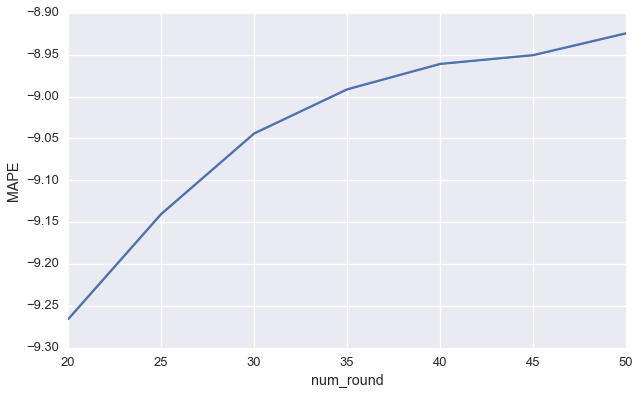

In [449]:
plot_quality(mygs, 'num_round')

eta = 0.15, min_child_weight = 1, intercept = 50

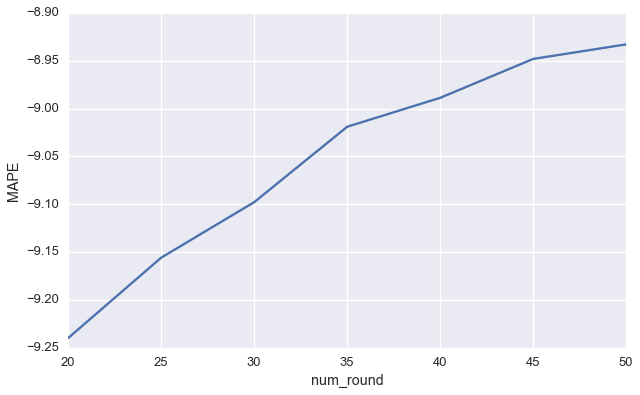

In [442]:
plot_quality(mygs, 'num_round')

In [443]:
gc.collect()

4308

# Save

In [144]:
%%time
est = LDTR(max_features=None, max_depth=15, random_state=42,
           n_coefficients=2, n_first_dropped=2, const_term=True, min_samples_leaf=40).fit(
    X=x_train, y=y_train, sample_weight=np.power(y_train.flatten(), -1))

CPU times: user 19 s, sys: 248 ms, total: 19.2 s
Wall time: 19.3 s


In [145]:
y_pred = est.predict(x_test)

In [146]:
save_to_file(y_pred, 'ldtr.csv')